In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
import random 
from efficientnet_pytorch import EfficientNet
import torchvision.transforms as transforms 
import pickle


from pynwb import NWBHDF5IO, NWBFile, TimeSeries
from pynwb.epoch import TimeIntervals
from pynwb.file import Subject

import matplotlib.pyplot as plt
from PIL import Image

import os
from pathlib import Path

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns)
from allensdk.brain_observatory.ecephys.visualization import raster_plot


pd.set_option("display.max_columns", None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/bastienll/Anaconda3/envs/UiO_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## test on nwb files

In [2]:
filepath = "./../data/ecephys_session_715093703.nwb"
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwbfile = io.read()
nwbfile

/home/bastienll/Anaconda3/envs/UiO_env/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bastienll/Anaconda3/envs/UiO_env/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


root pynwb.file.NWBFile at 0x140644724123536
Fields:
  acquisition: {
    raw_running_wheel_rotation <class 'pynwb.base.TimeSeries'>,
    running_wheel_signal_voltage <class 'pynwb.base.TimeSeries'>,
    running_wheel_supply_voltage <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    probeA <class 'abc.EcephysProbe'>,
    probeB <class 'abc.EcephysProbe'>,
    probeC <class 'abc.EcephysProbe'>,
    probeD <class 'abc.EcephysProbe'>,
    probeE <class 'abc.EcephysProbe'>,
    probeF <class 'abc.EcephysProbe'>
  }
  electrode_groups: {
    probeA <class 'abc.EcephysElectrodeGroup'>,
    probeB <class 'abc.EcephysElectrodeGroup'>,
    probeC <class 'abc.EcephysElectrodeGroup'>,
    probeD <class 'abc.EcephysElectrodeGroup'>,
    probeE <class 'abc.EcephysElectrodeGroup'>,
    probeF <class 'abc.EcephysElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  file_create_date: [datetime.datetime(2020, 5, 26, 0, 53, 26, 986608, tzinfo=tzoffset(None, -25200))]

In [3]:
nwbfile.intervals

{'drifting_gratings_presentations': drifting_gratings_presentations pynwb.epoch.TimeIntervals at 0x140644724124400
 Fields:
   colnames: ['start_time' 'stop_time' 'stimulus_name' 'stimulus_block'
  'temporal_frequency' 'color' 'mask' 'opacity' 'phase' 'size' 'units'
  'stimulus_index' 'orientation' 'spatial_frequency' 'contrast' 'tags'
  'timeseries']
   columns: (
     start_time <class 'hdmf.common.table.VectorData'>,
     stop_time <class 'hdmf.common.table.VectorData'>,
     stimulus_name <class 'hdmf.common.table.VectorData'>,
     stimulus_block <class 'hdmf.common.table.VectorData'>,
     temporal_frequency <class 'hdmf.common.table.VectorData'>,
     color <class 'hdmf.common.table.VectorData'>,
     mask <class 'hdmf.common.table.VectorData'>,
     opacity <class 'hdmf.common.table.VectorData'>,
     phase <class 'hdmf.common.table.VectorData'>,
     size <class 'hdmf.common.table.VectorData'>,
     units <class 'hdmf.common.table.VectorData'>,
     stimulus_index <class 'hdmf

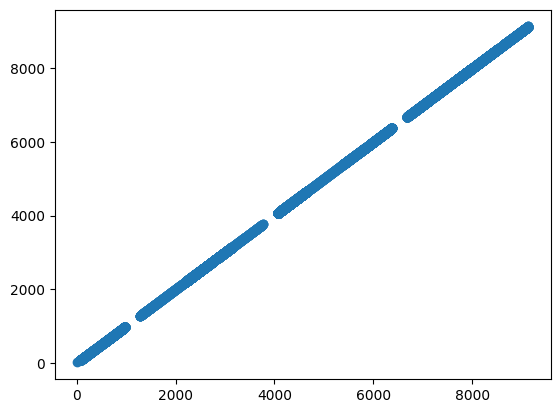

In [4]:
plt.scatter(nwbfile.intervals["static_gratings_presentations"].columns[16][1][0][2].data[:],nwbfile.intervals["static_gratings_presentations"].columns[16][1][0][2].timestamps[:])

In [ ]:
nwbfile.intervals["drifting_gratings_presentations"].colnames

In [ ]:
nwbfile.intervals["drifting_gratings_presentations"].colnames

## make gratings

In [ ]:
def grating(sp_frec, phase, angle):
    x = np.arange(0, 501, 1)
    wavelength = 1/sp_frec
    rad = angle * np.pi / 180
    X, Y = np.meshgrid(np.arange(0, 224, 1) , np.arange(0, 224, 1))
    grati = np.sin( 2 * np.pi * (X * np.cos(rad) + Y * np.sin(rad)) / wavelength + phase * 2 * np.pi)
    return (grati+1)*256/2
 


In [ ]:
i = 0
if not os.path.isfile('./../data/images/image_0.0.png'):
    for sp_frec in [0.02, 0.04, 0.08, 0.16, 0.32]:
        for phase in [0, 0.25, 0.5, 0.75]:
            for orientation in [0, 30, 60, 90, 120, 150]:
                grat = grating(sp_frec, phase, orientation)
                im = Image.new('L', (224, 224))
                im.putdata(grat.flatten().tolist())
                im.save("./../data/images/image_{}.0.png".format(i))
                i += 1

In [ ]:
transform = transforms.Compose([ 
    transforms.PILToTensor() 
]) 
im_tensor = torch.empty([1, 1, 224, 224])
for i in range(120):
    a = Image.open('./../data/gratings/grating_{}.0.tiff'.format(i))
    a = a.resize((224,224))
    a = transform(a).unsqueeze(1)
    im_tensor = torch.cat((im_tensor,a),0)
    del a 
for i in range(118):
    a = Image.open('./../data/natural_scene_templates/natural_scene_{}.0.tiff'.format(i))
    a = a.resize((224,224))
    a = transform(a).unsqueeze(1)
    im_tensor = torch.cat((im_tensor,a),0)
    del a
im_tensor = torch.cat((im_tensor,im_tensor,im_tensor), dim = 1).int().float()

In [ ]:
Eff=EfficientNet_b0()
temp1 = Eff.forward(im_tensor[:10,:,:,:])

## get spiking data

In [2]:
output_dir = './../data/'
resources_dir = Path.cwd().parent / 'resources'
DOWNLOAD_LFP = False

# Example cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc = BrainObservatoryCache(manifest_path)
data_set = boc.get_ophys_experiment_data(501498760)

# read in the array of images
if not os.path.isfile('./../data/natural_scene_templates/natural_scene_0.0.tiff'):
    scenes = data_set.get_stimulus_template('natural_scenes')
    count = 0
    for i in scenes:
        im = Image.new('L', (1174, 918))
        im.putdata(i.flatten().tolist())
        im.save("./../data/natural_scene_templates/natural_scene_{}.0.tiff".format(count))
        count += 1

In [4]:
cache.get_probes()[cache.get_probes()['name']== 'probeB'].head()

,ecephys_session_id,lfp_sampling_rate,name,phase,sampling_rate,has_lfp_data,unit_count,channel_count,ecephys_structure_acronyms
id,,,,,,,,,
729445650,719161530,1249.996620,probeB,3a,29999.918880,True,202,368,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan]"
733744647,732592105,1249.996475,probeB,3a,29999.915391,True,174,369,"[grey, VISpm, nan]"
756781555,754312389,1249.996564,probeB,3a,29999.917524,True,73,370,"[LGd, HPF, DG, CA3, CA1, VISpm, nan]"
757904510,744228101,1249.996287,probeB,3a,29999.910883,True,144,368,"[Eth, TH, LP, POL, APN, DG, CA1, VIS, nan]"
757904547,750332458,1249.996591,probeB,3a,29999.918181,True,125,369,"[grey, VISpm, nan]"


In [25]:
sessions = cache.get_session_table()
p = 0
sessions.index[p]

715093703

In [26]:
sessions = cache.get_session_table()
session = cache.get_session_data(sessions.index[p])

In [27]:
units_probeC = session.units.loc[session.units['probe_description'] == 'probeB']
ProbeC_unit_ids = units_probeC.index.values

In [28]:
static_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'static_gratings') |
    (session.stimulus_presentations['stimulus_name'] == 'natural_scenes')
].index.values

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=static_presentation_ids,
    unit_ids=ProbeC_unit_ids)

del ProbeC_unit_ids

In [29]:
tim = times.groupby(['stimulus_presentation_id','unit_id']).count().reset_index().pivot(index = 'unit_id', columns= 'stimulus_presentation_id').fillna(0)
stim_presentation_id = tim.columns.get_level_values(1).to_list()
del times
tim.head()


time_since_stimulus_presentation_onset              \
stimulus_presentation_id                                  49432 49433 49434   
unit_id                                                                       
950913409                                                   8.0   6.0   6.0   
950913422                                                   3.0   7.0   9.0   
950913456                                                   8.0   7.0  11.0   
950913470                                                   2.0   1.0   3.0   
950913506                                                   9.0   2.0   6.0   

                                                                          \
stimulus_presentation_id 49435 49436 49437 49438 49439 49440 49441 49442   
unit_id                                                                    
950913409                  0.0   6.0   6.0   3.0   4.0   8.0   9.0   4.0   
950913422                  4.0   3.0   4.0   4.0   2.0   4.0   6.0   5.0   
950913456                 11.0   8.0  10.0  11.0   7.0   6.0   2.0   4.0   
950913470                  4.0   3.0   3.0   0.0   3.0   1.0   3.0   0.0   
950913506                  6.0   9.0   3.0   7.0  12.0  10.0   3.0   0.0   

                                                                          \
stimulus_presentation_id 49443 49444 49445 49446 49447 49448 49449 49450   
unit_id                                                                    
950913409                  9.0   8.0   3.0  11.0  11.0   7.0   5.0   6.0   
950913422                  7.0   4.0   7.0   8.0  10.0   6.0   5.0   1.0   
950913456                 13.0   4.0  11.0   6.0   8.0   7.0   4.0   5.0   
950913470                  5.0   5.0   4.0   0.0   3.0   0.0   1.0   2.0   
950913506                  3.0   7.0   0.0   2.0   6.0   0.0   1.0   0.0   

                                                                          \
stimulus_presentation_id 49451 49452 49453 49454 49455 49456 49457 49458   
unit_id                                                                    
950913409                  2.0   1.0   1.0   1.0   5.0   5.0  11.0   8.0   
950913422                  3.0   4.0   3.0   3.0   6.0   5.0   5.0   4.0   
950913456                  3.0   3.0   4.0   8.0   3.0   7.0   5.0   8.0   
950913470                  3.0   2.0   4.0   4.0   7.0   0.0   0.0   1.0   
950913506                  0.0   1.0   0.0   6.0   2.0  13.0   0.0   0.0   

                                                                          \
stimulus_presentation_id 49459 49460 49461 49462 49463 49464 49465 49466   
unit_id                                                                    
950913409                  9.0   7.0   1.0   2.0   2.0   1.0   4.0   1.0   
950913422                  4.0   6.0   5.0   1.0   2.0  10.0   5.0   7.0   
950913456                  5.0   6.0   5.0   4.0   5.0   5.0   4.0   4.0   
950913470                  0.0   0.0   1.0   0.0   9.0   3.0   6.0   0.0   
950913506                  0.0   1.0   0.0   1.0   1.0   1.0   7.0   3.0   

                                                                          \
stimulus_presentation_id 49467 49468 49469 49470 49471 49472 49473 49474   
unit_id                                                                    
950913409                  4.0   1.0   6.0   4.0   2.0   0.0   0.0   2.0   
950913422                 11.0   8.0   3.0   6.0   4.0   4.0   3.0   2.0   
950913456                  7.0   6.0   2.0   6.0   5.0   4.0   7.0   5.0   
950913470                  0.0   3.0   3.0   2.0   0.0   2.0   3.0   1.0   
950913506                  5.0   1.0   2.0   5.0   1.0   1.0   2.0   9.0   

                                                                          \
stimulus_presentation_id 49475 49476 49477 49478 49479 49480 49481 49482   
unit_id                                                                    
950913409                  5.0   6.0   9.0   6.0   6.0   4.0  11.0   5.0   
950913422                  6.0   5.0   6.0 

In [30]:
positions = session.units[['anterior_posterior_ccf_coordinate'	,'dorsal_ventral_ccf_coordinate',	'left_right_ccf_coordinate']]
position = positions[positions.index.isin(tim.index)]
print(position.shape)
file = open('./postionB{}'.format(p), 'wb')
pickle.dump(position, file)
file.close()

(167, 3)


In [23]:
#build a correspondance table for stimulus presentation -> input image or natural scene
st_gr = session.get_stimulus_table(['static_gratings']).reset_index()
st_gr = st_gr[st_gr['stimulus_presentation_id'].isin(stim_presentation_id)][['stimulus_presentation_id','orientation','phase','spatial_frequency']]
st_gr['ind'] = st_gr['orientation'].astype('str') + st_gr['phase'].astype('str') + st_gr['spatial_frequency'].astype('str')
st_gr = st_gr.set_index(['ind']).sort_index()
gratings_corespondance = pd.merge(st_gr.groupby(st_gr.index).sum().reset_index().reset_index(),st_gr, on='ind')[['index','stimulus_presentation_id_y']].rename(columns = {'stimulus_presentation_id_y':'stimulus_presentation_id'})
gratings_corespondance['index'].replace(120.0, np.nan, inplace = True)
st_gr = session.get_stimulus_table(['natural_scenes']).reset_index()
st_gr = st_gr[st_gr['stimulus_presentation_id'].isin(stim_presentation_id)][['stimulus_presentation_id','frame']]
coresponding = pd.merge(gratings_corespondance, st_gr, on = 'stimulus_presentation_id', how = 'outer').set_index('stimulus_presentation_id')
coresponding.drop(coresponding[coresponding['index']!=coresponding['index']][coresponding['frame']!=coresponding['frame']].index,inplace = True)
coresponding['count'] = coresponding['index'].replace(np.nan,0)+(coresponding['frame']+120).replace(np.nan,0)
coresponding['res'] = ('image_'+ coresponding['frame'].astype('str')).replace('image_nan','')+('grating_'+ coresponding['index'].astype('str')).replace('grating_nan','')
coresponding = coresponding[['res','count']]

/tmp/ipykernel_4799/3379812059.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gratings_corespondance = pd.merge(st_gr.groupby(st_gr.index).sum().reset_index().reset_index(),st_gr, on='ind')[['index','stimulus_presentation_id_y']].rename(columns = {'stimulus_presentation_id_y':'stimulus_presentation_id'})


In [47]:
dat = pd.concat([coresponding[['count']], tim.T.reset_index().drop('level_0', axis = 1).set_index('stimulus_presentation_id')], axis = 1)

In [48]:
dat.dropna()
dat['count'] = dat.dropna()['count'].astype(int)

In [49]:
dat.shape

(10604, 260)

In [50]:
sesh = session.stimulus_presentations[session.stimulus_presentations.index.isin(dat.index)][['start_time']].sort_values('start_time').reset_index()[['stimulus_presentation_id']].reset_index()
sesh = pd.merge(dat[['count']],sesh, left_on= dat.index,right_on = sesh.stimulus_presentation_id ).set_index('stimulus_presentation_id')[['count','index']]
temp = []
for i in sesh['index']:
    if i !=0:
        if float(sesh['count'][sesh['index']==i-1]) == float(sesh['count'][sesh['index']==i-1]):
            temp.append(float(sesh['count'][sesh['index']==i-1]))
        else:
            temp.append(-999)
    else:
        temp.append(-1)
sesh['previous'] = temp

In [53]:
sesh.sort_values('index')

,count,index,previous
stimulus_presentation_id,,,
49432,34.0,0,-1.0
49433,52.0,1,34.0
49434,94.0,2,52.0
49435,36.0,3,94.0
49436,40.0,4,36.0
...,...,...,...
70383,96.0,10599,66.0
70384,100.0,10600,96.0
70385,82.0,10601,100.0


In [56]:
dat = pd.merge(dat,sesh[['index']], left_on = dat.index, right_on =sesh.index).set_index('key_0')
dat.index.names = ['stimulus_presentation_id']

In [61]:
dat.dropna(subset=['count'], inplace = True)


In [ ]:

file = open('dat_test', 'wb')
pickle.dump(dat.sort_values('index'), file)
file.close()


In [ ]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[10]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()